In [2]:
import gymnasium as gym
import pygame
import matplotlib.pyplot as plt
import numpy as np


from scipy.signal import savgol_filter

q_table = None



## Reinforcement Learning

The **reinforcement learning** is a paradigm of machine learning that often relies on the interaction of **agent** and **environment**.


This is a diagram of the **Markov Decision Process**, which is the best friend of RL and probabilistic decision-making models in general. We'll refer to it as **MDP** for short.

---

### MDP

The **MDP** is described with:
- **States**: all possible states the agent could encounter, $s \in \mathcal{S}$
- **Actions**: set of possible actions, $a \in \mathcal{A}(s)$, for every state
- **Rewards**: set of rewards for $r = R(s) \in \mathbb{R}$, meaning all states have some reward (or none)

---

Also, to explain the main idea of the MDP, we should have **discrete time steps**:
$$ t \in \{0, 1, 2, \dots, n\}$$

MDP has an assumption that **previous steps don't affect the underlying probability distribution**, then it looks like:

$$
p(s', r \mid s, a)
$$

MDP defines the probability of getting new state $s'$ and receiving reward $r$ after taking action $a$ in state $s$.

MDP describes the **environment**, and the **agent** behavior is described within **policy**.

---

## Policy $\pi$

Policy $\pi(a \mid s)$ tells the **probability of taking a particular action** $a$ among $\mathcal{A}(s)$ when being in state $s$.

---

## Return $G_t$

Now we have defined the environment and agent and could even test the setup.

For this test, the authors (of the setup) follow the **uniform distribution** — this is called the **random policy**.

Now the agent is performing **random actions**, completing the **SARSA loop**, but now it is practically useless.
We need to introduce the way to **improve policy**.

---

### Return $G_t$

The return $G_t$ is **accumulated rewards over all future time steps**.
Also, we want to consider **closer rewards as more valuable** — for that, we add **discount factor** $\gamma$, so:

$$
G_t = \sum_{k=t+1}^{T} \gamma^{k - t - 1} R_k
$$

---

With the idea of return formalized, the **goal for optimal policy** might be described as **maximizing expected return**:

$$
\pi^* = \arg\max_{\pi} \mathbb{E}_\pi [G_t]
$$

---

Let me know if you'd like this exported as a `.md` file or need it translated to another format like PDF or LaTeX source.

In [26]:
def run(episodes = 1):
    pygame.init()
    env = gym.make("FrozenLake-v1", is_slippery=True, render_mode="human")
    policy = np.arange(env.action_space.n)

    action_map = {
        0: "LEFT",
        1: "DOWN",
        2: "RIGHT",
        3: "UP"
    }

    for i in range(episodes):
        state = env.reset()[0]
        print(f"Initial state is [{state // 8}, {state % 8}]")
        terminated = False
        truncated = False

        while(not terminated and not truncated):
            action = np.random.choice(policy)
            print(f"Action is {action_map[action]}]")
            new_state, reward, terminated, truncated,_ = env.step(action)

            print(f"New state is [{new_state // 8}, {new_state % 8}], reward is {reward}")

    env.close()

    pygame.quit()

In [27]:
run(episodes = 1)

Initial state is [0, 0]
Action is LEFT]
New state is [0, 4], reward is 0.0
Action is UP]
New state is [0, 4], reward is 0.0
Action is RIGHT]
New state is [0, 0], reward is 0.0
Action is UP]
New state is [0, 1], reward is 0.0
Action is RIGHT]
New state is [0, 1], reward is 0.0
Action is UP]
New state is [0, 0], reward is 0.0
Action is RIGHT]
New state is [0, 1], reward is 0.0
Action is RIGHT]
New state is [0, 5], reward is 0.0


Episode 0 | Success: False | Epsilon: 0.9998888888888889
Episode 1 | Success: False | Epsilon: 0.9997777777777779
Episode 2 | Success: False | Epsilon: 0.9996666666666668
Episode 3 | Success: False | Epsilon: 0.9995555555555558
Episode 4 | Success: False | Epsilon: 0.9994444444444447
Episode 5 | Success: False | Epsilon: 0.9993333333333336
Episode 6 | Success: False | Epsilon: 0.9992222222222226
Episode 7 | Success: False | Epsilon: 0.9991111111111115
Episode 8 | Success: False | Epsilon: 0.9990000000000004
Episode 9 | Success: False | Epsilon: 0.9988888888888894
Episode 10 | Success: False | Epsilon: 0.9987777777777783
Episode 11 | Success: False | Epsilon: 0.9986666666666673
Episode 12 | Success: False | Epsilon: 0.9985555555555562
Episode 13 | Success: False | Epsilon: 0.9984444444444451
Episode 14 | Success: False | Epsilon: 0.9983333333333341
Episode 15 | Success: False | Epsilon: 0.998222222222223
Episode 16 | Success: False | Epsilon: 0.998111111111112
Episode 17 | Success: Fals

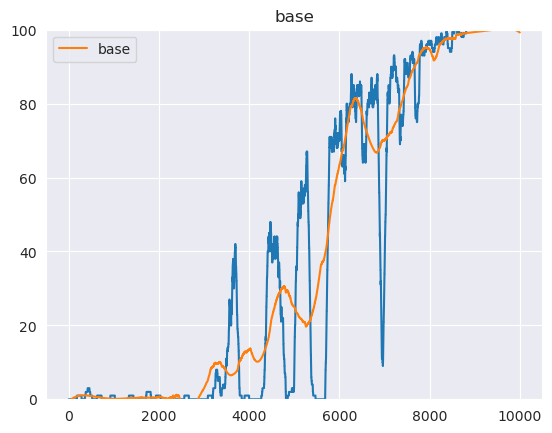

In [43]:
def train(
        episodes=4000,
        lr=1e-2,
        gamma=0.9,
        td_num=4,
        cost_of_living=0.01,
        T=100,
        render=False,
        isSlippery=True,
        label="base"):

    pygame.init()
    global q_table
    env = gym.make("FrozenLake8x8-v1", is_slippery=isSlippery, render_mode='human' if render else None)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    epsilon = 1
    epsilon_decay = 1/(episodes * 0.9)
    rewards_per_episode = np.zeros(episodes)
    time_rewards_per_episode = np.zeros(episodes)
    steps_per_episode = []

    for episode in range(episodes):
        trajectory = []
        state = env.reset()[0]
        steps = 0
        episode_success = False

        for t in range(T):
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            new_state, reward, terminated, truncated, _ = env.step(action)
            steps += 1

            # Adjust reward for falling into a hole
            if terminated and reward == 0:
                reward = -1
            # Check if reached the goal before subtracting cost_of_living
            if reward == 1:
                episode_success = True

            # Apply cost of living to the reward
            reward -= cost_of_living

            # Store transition with termination info
            trajectory.append((state, action, reward, new_state, terminated))

            # Process n-step updates
            while len(trajectory) >= td_num:
                # Pop the oldest transition
                oldest_state, oldest_action, oldest_reward, oldest_new_state, oldest_terminated = trajectory.pop(0)

                G = oldest_reward
                current_gamma = gamma
                term_in_window = oldest_terminated

                # Sum rewards for next (td_num-1) steps or until termination
                for k in range(1, td_num):
                    if (k-1) >= len(trajectory):
                        break
                    entry = trajectory[k-1]
                    r_k, term_k = entry[2], entry[4]
                    G += current_gamma * r_k
                    current_gamma *= gamma
                    if term_k:
                        term_in_window = True
                        break

                # Add discounted Q-value if no termination in the window
                if not term_in_window and len(trajectory) >= (td_num-1):
                    last_entry = trajectory[td_num-2]  # Changed from td_num-1 to td_num-2
                    last_state = last_entry[3]
                    if not last_entry[4]:  # Check if last state is not terminal
                        G += current_gamma * np.max(q_table[last_state])

                # Update Q-value
                q_table[oldest_state][oldest_action] += lr * (G - q_table[oldest_state][oldest_action])

            state = new_state
            if terminated or truncated:
                break

        # Process remaining transitions after episode ends
        while len(trajectory) > 0:
            oldest_entry = trajectory.pop(0)
            s, a, r, s_new, term = oldest_entry

            G = r
            current_gamma = gamma
            term_in_steps = term

            for k in range(1, len(trajectory)+1):
                if (k-1) >= len(trajectory):
                    break
                entry = trajectory[k-1]
                r_k, term_k = entry[2], entry[4]
                G += current_gamma * r_k
                current_gamma *= gamma
                if term_k:
                    term_in_steps = True
                    break

            # No Q-value added after episode termination
            q_table[s][a] += lr * (G - q_table[s][a])

        # Track success and steps
        rewards_per_episode[episode] = 1 if episode_success else 0
        if episode_success:
            time_rewards_per_episode[episode] = 1 - cost_of_living * steps
            steps_per_episode.append(steps)

        # Decay exploration and learning rate
        epsilon = max(epsilon - epsilon_decay, 0)
        if epsilon == 0:
            lr *= 0.1  # Decay learning rate after exploration stops

        print(f"Episode {episode} | Success: {episode_success} | Epsilon: {epsilon}")

    env.close()
    pygame.quit()

    # Plotting and statistics code remains the same...
    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)

    moving_average_window = episodes // 4
    moving_averages = savgol_filter(rewards_per_episode * 100, moving_average_window, 5)

    plt.plot(moving_averages, label=f'{label}')
    plt.ylim(0, 100)
    plt.title(label)
    plt.legend()

    print("__________________________________")
    print(f"{label}")
    mean_reward_rate = np.mean(rewards_per_episode[int(len(rewards_per_episode)*0.9):])
    print(f"Mean reward rate: {mean_reward_rate}")
    if steps_per_episode:
        mean_steps = np.mean(steps_per_episode[int(len(steps_per_episode)*0.9):])
        print(f"Mean steps per success episode: {mean_steps}")
    else:
        print("No successful episodes to calculate mean steps.")

# Example usage
train(episodes=10000, td_num=4, lr=0.1, isSlippery=False)

In [40]:
def train(episodes=4000,
          learning_rate=0.1,
          discount_factor=0.9,
          cost_of_living=0.01,
          T = 100,
          render=False,
          isSlippery = True,
          label ='base'):

    pygame.init()

    global q_table
    env = gym.make("FrozenLake8x8-v1", is_slippery = isSlippery, render_mode= 'human' if render else None)

    q_table = np.zeros([env.observation_space.n, env.action_space.n])


    epsilon = 1
    epsilon_decay = 1/(episodes * 0.9)
    random_number_generator = np.random.default_rng()
    rewards_per_episode = np.zeros(episodes)
    time_rewards_per_episode = np.zeros(episodes)
    steps_per_episode = []

    for i in range(episodes):
        state = env.reset()[0]
        steps = 0

        for step in range(T):
            if random_number_generator.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state, :])

            new_state, reward, terminated, truncated,_ = env.step(action)

            if terminated & (reward == 0):
                reward = reward - 1

            if reward == 1:
                rewards_per_episode[i] = 1
                time_rewards_per_episode[i] = 1 - steps *  cost_of_living
                steps_per_episode.append(steps)
                reward = reward - cost_of_living * steps


            q_table[state, action] += learning_rate * (reward + discount_factor * np.max(q_table[new_state, :]) - q_table[state, action])

            state = new_state

            steps += 1

            if terminated or truncated:
                break


        epsilon = max(epsilon - epsilon_decay, 0)

        if epsilon == 0:
            learning_rate = learning_rate * 0.1



        print(f"Episode {i} | rewards {time_rewards_per_episode[i]} | Epsilon {epsilon}")

    env.close()
    pygame.quit()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes) :
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)


    moving_average_window = episodes // 4
    moving_averages = savgol_filter(rewards_per_episode * 100 , moving_average_window, 5)

    plt.plot(moving_averages, label=f'{label}')

    plt.ylim(0, 100)

    plt.title(label)

    plt.legend()

    print("__________________________________")

    print(f"{label}")

    mean_reward_rate = np.mean(rewards_per_episode[int(len(rewards_per_episode) * 0.9):])
    print(f"Mean reward rate: {mean_reward_rate}")

    mean_steps = np.mean(steps_per_episode[int(len(steps_per_episode) * 0.9):])
    print(f"Mean steps per success episode: {mean_steps}")




def run(episodes = 1):
    global q_table
    pygame.init()
    env = gym.make("FrozenLake8x8-v1", is_slippery=True, render_mode= 'human')

    for i in range(episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False

        while(not terminated and not truncated):
            action = np.argmax(q_table[state, :])

            new_state, reward, terminated, truncated,_ = env.step(action)

            state = new_state

    env.close()

    pygame.quit()


Episode 0 | rewards 0.0 | Epsilon 0.9997222222222222
Episode 1 | rewards 0.0 | Epsilon 0.9994444444444444
Episode 2 | rewards 0.0 | Epsilon 0.9991666666666665
Episode 3 | rewards 0.0 | Epsilon 0.9988888888888887
Episode 4 | rewards 0.0 | Epsilon 0.9986111111111109
Episode 5 | rewards 0.0 | Epsilon 0.9983333333333331
Episode 6 | rewards 0.0 | Epsilon 0.9980555555555553
Episode 7 | rewards 0.0 | Epsilon 0.9977777777777774
Episode 8 | rewards 0.0 | Epsilon 0.9974999999999996
Episode 9 | rewards 0.0 | Epsilon 0.9972222222222218
Episode 10 | rewards 0.0 | Epsilon 0.996944444444444
Episode 11 | rewards 0.0 | Epsilon 0.9966666666666661
Episode 12 | rewards 0.0 | Epsilon 0.9963888888888883
Episode 13 | rewards 0.0 | Epsilon 0.9961111111111105
Episode 14 | rewards 0.0 | Epsilon 0.9958333333333327
Episode 15 | rewards 0.0 | Epsilon 0.9955555555555549
Episode 16 | rewards 0.0 | Epsilon 0.995277777777777
Episode 17 | rewards 0.0 | Epsilon 0.9949999999999992
Episode 18 | rewards 0.0 | Epsilon 0.994

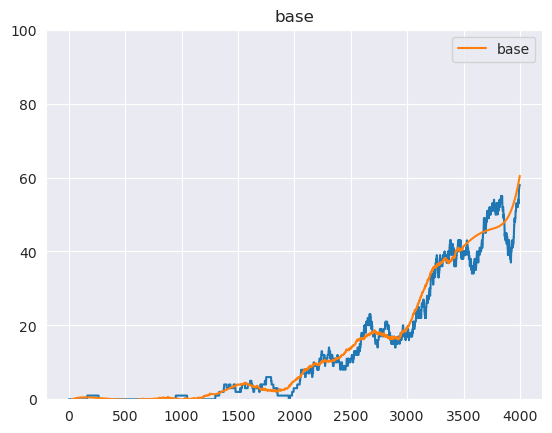

In [41]:
train()

In [28]:
run(episodes=4)

In [12]:
q_table

array([[ 4.71116050e-02,  5.05570553e-02,  5.23139370e-02,
         7.49344384e-02],
       [ 5.84236889e-02,  6.90297633e-02,  9.11266185e-02,
         7.04000005e-02],
       [ 8.81198606e-02,  1.00283523e-01,  1.30249067e-01,
         9.66632515e-02],
       [ 1.24562120e-01,  1.43106338e-01,  1.94107600e-01,
         1.27620332e-01],
       [ 1.77578397e-01,  2.07978895e-01,  2.58395375e-01,
         1.96716972e-01],
       [ 2.52364432e-01,  2.71038039e-01,  3.51852535e-01,
         2.83683260e-01],
       [ 3.67955297e-01,  3.86130056e-01,  4.35165760e-01,
         3.65065489e-01],
       [ 4.57015870e-01,  4.57085327e-01,  4.64595452e-01,
         4.38171938e-01],
       [ 3.86949744e-02,  4.24399655e-02,  4.63649422e-02,
         6.22361694e-02],
       [-3.59471983e-02, -2.47139484e-02, -6.65038307e-03,
         8.08339598e-02],
       [-3.10314353e-01, -3.41089436e-01, -1.43171898e-01,
         1.06176479e-01],
       [-6.44801713e+00, -5.41304792e+00, -1.07294716e+01,
      

__________________________________
LR 0.0001
Mean reward rate: 0.0
Mean steps per success episode: 71.0
__________________________________
LR 0.01
Mean reward rate: 0.045
Mean steps per success episode: 68.33333333333333
__________________________________
LR 0.1
Mean reward rate: 0.555
Mean steps per success episode: 63.233333333333334
__________________________________
LR 0.5
Mean reward rate: 0.39
Mean steps per success episode: 63.05882352941177


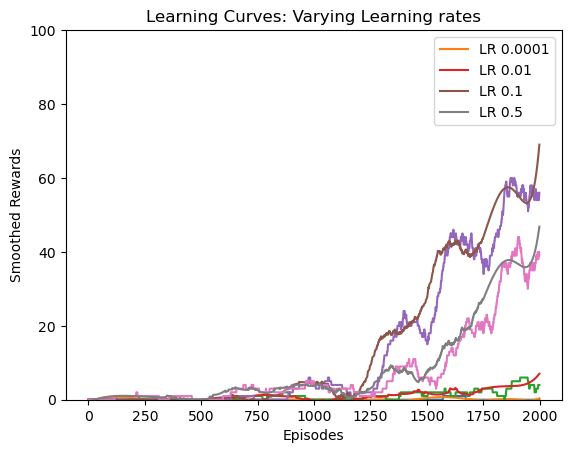

In [13]:
train(episodes=2000, learning_rate=0.0001, label="LR 0.0001")
train(episodes=2000, learning_rate=0.01, label="LR 0.01")
train(episodes=2000, learning_rate=0.1, label="LR 0.1")
train(episodes=2000, learning_rate=0.5, label="LR 0.5")

plt.title("Learning Curves: Varying Learning rates")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Rewards")
plt.legend()
plt.show()


__________________________________
DF 0.99
Mean reward rate: 0.517
Mean steps per success episode: 66.1063829787234
__________________________________
DF 0.2
Mean reward rate: 0.267
Mean steps per success episode: 66.10759493670886


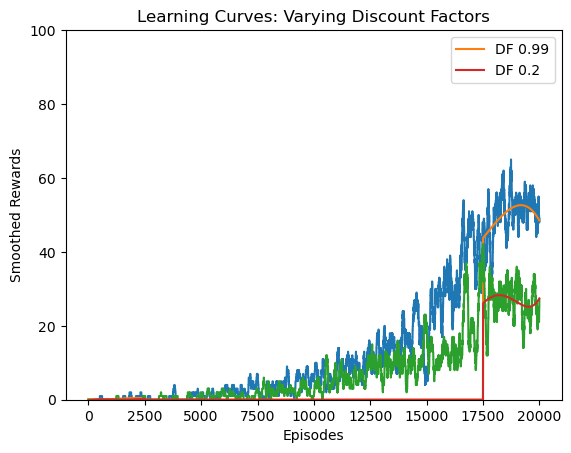

In [14]:
# Different Discount Factors
train(episodes=20000, discount_factor=0.99, label="DF 0.99")
train(episodes=20000, discount_factor=0.2, label="DF 0.2")

plt.title("Learning Curves: Varying Discount Factors")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Rewards")
plt.legend()
plt.show()

__________________________________
10000 episodes
Mean reward rate: 0.428
Mean steps per success episode: 66.49557522123894
__________________________________
20000 episodes
Mean reward rate: 0.58
Mean steps per success episode: 63.181268882175225
__________________________________
40000 episodes
Mean reward rate: 0.5945
Mean steps per success episode: 63.80209895052474
__________________________________
100000 episodes
Mean reward rate: 0.5479
Mean steps per success episode: 64.19646125686394


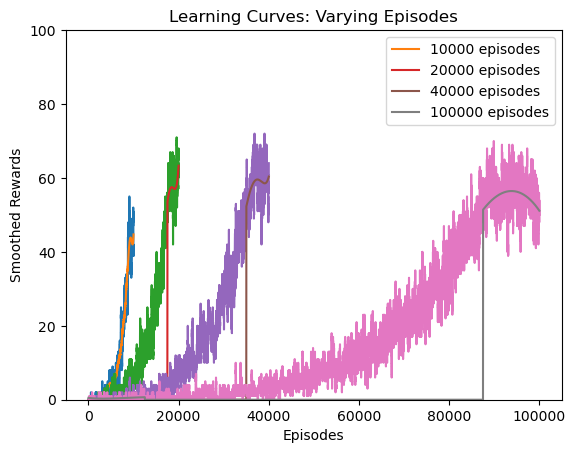

In [15]:
train(episodes=10000, learning_rate=0.01, label="10000 episodes")

train(episodes=20000, learning_rate=0.01, label="20000 episodes")

train(episodes=40000, learning_rate=0.01, label="40000 episodes")

train(episodes=100000, learning_rate=0.01, label="100000 episodes")

plt.title("Learning Curves: Varying Episodes")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Rewards")
plt.legend()
plt.show()
